In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from descriptors.preprocessing import preprocess

## Feature importance analysis - General

In [9]:
# Preprocess de NiColit...
from descriptors.chemical_analysis import feat_dft_nicolit, principal_descriptors, perf_param, radar_factory
data_path = 'data/utils/'
nicolit= pd.read_csv("data/NiCOlit.csv")
nicolit, indexes = preprocess(nicolit)

feat_dft_nicolit(nicolit, data_path)

In [10]:
# little supplementary preprocessing d
nicolit_float = nicolit.select_dtypes(include=[np.float64])
nicolit_float.drop(columns=['isolated_yield', 'polarisabilite', 'Unnamed: 9'], inplace=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = nicolit_float.values
X = scaler.fit_transform(X)
nicolit_float[nicolit_float.columns] = X

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


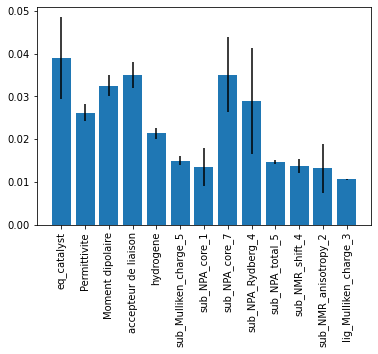

Li
(0.40211765364587915, 0.038852598858218214)


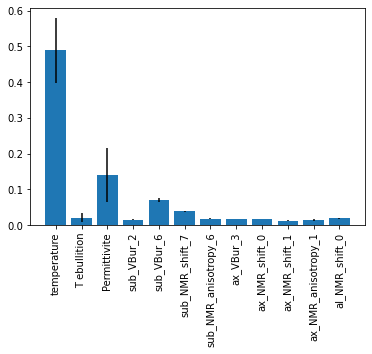

Zn
(0.37221463638316327, 0.032382289647431964)


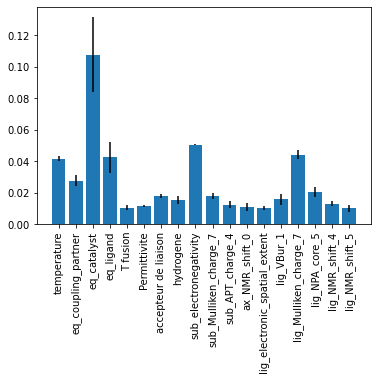

RMgX
(0.4784560683674489, 0.03940045958554494)


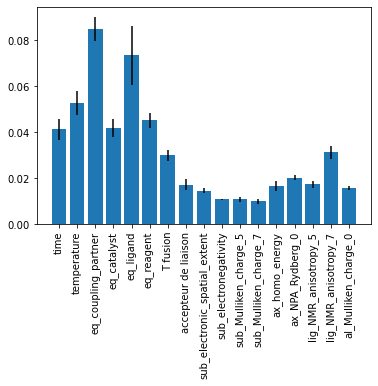

B
(0.5091642657710893, 0.037980236937093244)


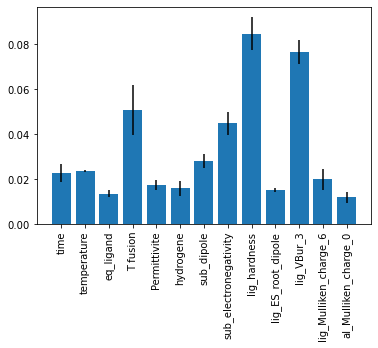

C-H
(0.4687140995665377, 0.04928752583915461)


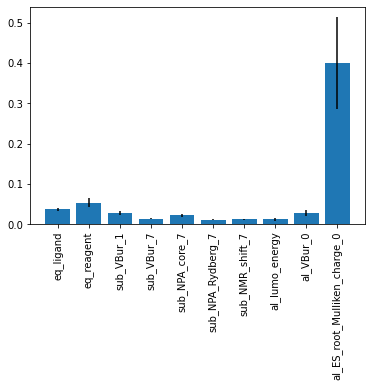

NCO
(0.37589232343408396, 0.0419590567729885)


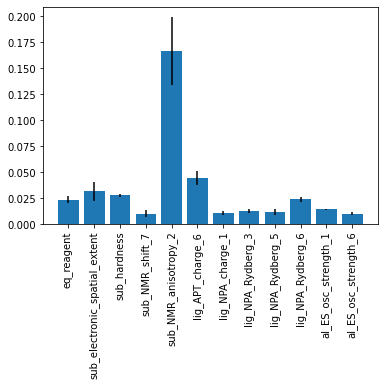

CO2
(0.46562646645559136, 0.02684921619049119)


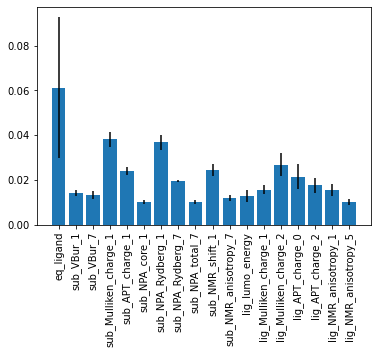

NH
(0.4180649735517126, 0.03874197799428375)


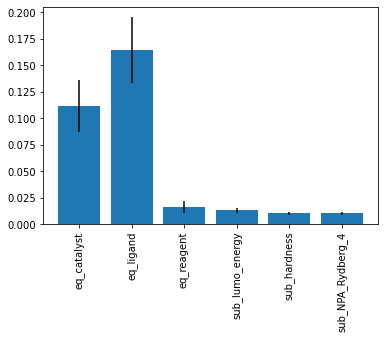

Si
(0.34172535352142885, 0.03195077728124488)


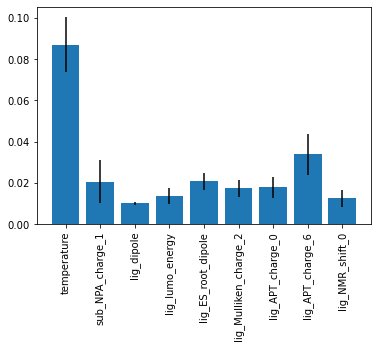

Al
(0.4008757896895559, 0.03406133270547663)


In [11]:
# this cell generates:
# 1. the features importances of all parameters for each model trained on reactions belonging to one class of coupling partners.
# 2. plots barplots woth the relative importance f the features that have more than 1% importance
# 3. trains a RF model with the parameters that show more than 1% importance from previous analysis
# 4. displays the performances
# 5. all this results are stored in Pi and R2 for next radar plots.

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
n_rep = 3
Pi = [] # list with all the permutation importances by coupling partner class
R  = [] # list with all model performances

coupling_partner_classes = nicolit.coupling_partner_class.unique()

for cp in coupling_partner_classes:
    nicolit_restr = nicolit_float[nicolit['coupling_partner_class'] == cp]
    nicolit_restr = nicolit_restr.select_dtypes(include=[np.float64])
    #nicolit_float.drop(columns=['polarisabilite', 'Unnamed: 9'], inplace=True)
    L = list(nicolit_float.columns)
    L.remove("yield")
    regr = RandomForestRegressor()
    X = nicolit_restr.drop(columns=['yield']).values
    y = nicolit_restr['yield']
    regr.fit(X,y)
    pi = permutation_importance(regr, X, y, 
                                scoring=None, 
                                n_repeats=n_rep,
                                max_samples=3.0)
    Pi.append(pi)
    PC = principal_descriptors(pi, L)
    print(cp)
    print(perf_param(nicolit_float, PC[0]))
    R.append(PC)

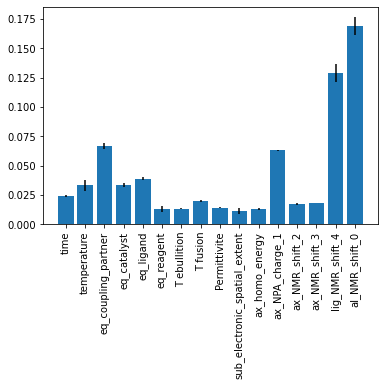

full
(0.4475718044012635, 0.03307702706595553)


In [12]:
# this cell does the same as the previous one but for the whole dataset.
# Pi and R2 are updated
nicolit_full = nicolit_float.select_dtypes(include=[np.float64])
regr = RandomForestRegressor()
X = nicolit_float.drop(columns=['yield']).values
y = nicolit_float['yield']
regr.fit(X,y)
pi = permutation_importance(regr, X, y, 
                            scoring=None, 
                            n_repeats=n_rep,
                            max_samples=3.0)
L = list(nicolit_full.columns)
L.remove("yield")
PC = principal_descriptors(pi, L)
print("full")
print(perf_param(nicolit_full, PC[0]))
Pi.append(pi)
R.append(PC)

In [13]:
# get dataframe with importances
df_dict = {}
values = []
L = nicolit_float.columns.to_list()
L.remove('yield')
for j, cp  in enumerate(coupling_partner_classes):
    df_dict.update({cp:pd.DataFrame.from_dict(data=Pi[j], orient='index', columns=L)})
# add full
df_dict.update({'full':pd.DataFrame.from_dict(data=Pi[j+1], orient='index', columns=L)})

In [14]:
# Radar plot for mean importance in model for each model
#1.  display attributes and classes
nicolit_float.columns
tT = ['time', 'temperature']
sol = ['T ebullition', 'T fusion', 'Permittivite','Moment dipolaire',
       'donneur de liaison hydrogene', 'accepteur de liaison', 'hydrogene']
eq = [i for i in nicolit_float.columns if 'eq_' in i]
sub = [i for i in nicolit_float.columns if 'sub_' in i]
AX = [i for i in nicolit_float.columns if 'ax_' in i]
lig = [i for i in nicolit_float.columns if 'lig_' in i]
al = [i for i in nicolit_float.columns if 'al_' in i[:3]]

comps = ['tT', 'solvent', 'molar ratios', 'substrate', 'coupling partner',
        'ligand', 'lewis acid']


#2.  plot radar plot for one model
def get_radars(cp, df_dict, n_rep):
    radar_mean = []
    for comp in [tT, sol, eq, sub, AX, lig, al]:   
        mean_imp_comp = np.sum(df_dict[cp][comp].loc['importances_mean'])
        radar_mean.append(mean_imp_comp)

    all_tests = df_dict[cp][comp].loc['importances']
    all_radars =[]
    for i in range(n_rep):
        radar_single = []
        for comp in [tT, sol, eq, sub, AX, lig, al]:   
            mean_imp_comp = df_dict[cp][comp].loc['importances']
            comp_single = np.sum([mean_imp_comp[j][i] for j in range(np.shape(mean_imp_comp)[0])])
            radar_single.append(comp_single)
        all_radars.append(radar_single)
    
    return radar_mean, all_radars

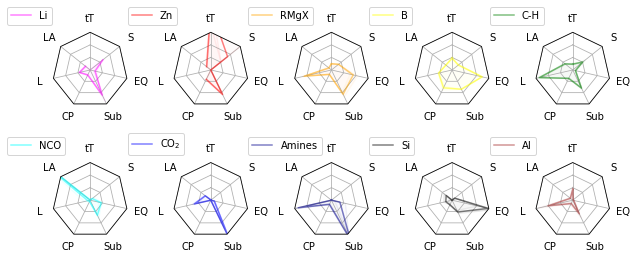

In [17]:
#3.  plot radar plot for all models
from math import pi

nrows = 2
ncols = np.trunc(len(coupling_partner_classes)/2)

# number of variable
categories=comps
categories_labels = ['tT', 'S', 'EQ', 'Sub', 'CP', 'L', 'LA']
N = len(categories)
# Initialise the spider plot
theta = radar_factory(N, frame='polygon')


fig, axs = plt.subplots(figsize=(10,  4), nrows=2, ncols=5,
                            subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

def plot_radar(cp, ax, color, df_dict=df_dict, n_rep=n_rep):
    dict_labels = {'Li':'Li', 'Zn':'Zn', 'RMgX':'RMgX', 'B':'B', 'C-H':'C-H', 
                'NCO':'NCO', 'CO2':'CO$_2$', 'NH':'Amines', 'Si':'Si', 'Al':'Al', 'full': 'full'}
    radar, all_radars = get_radars(cp=cp, df_dict=df_dict, n_rep=n_rep)
    ax.plot(theta, radar, color=color, alpha=0.5, label=dict_labels[cp])
    for i in range(len(all_radars)):
        ax.plot(theta, all_radars[i], color=color, alpha=0.05)
        ax.fill(theta, all_radars[i], color=color, alpha=0.01)
    ax.set_rgrids([0.1, 0.2, 0.3], labels=["","",""])
    ax.set_rlim([0,0.3])
    ax.set_varlabels(categories_labels)
    ax.set_rlabel_position(0)
    ax.set_theta_direction(-1)
    ax.legend(loc=[-0.6,1.1], fontsize='10')

colors= ['magenta', 'red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'Darkblue',
        'black', 'brown']

for i, cp  in enumerate(coupling_partner_classes):
    if i < 5:
        ncol = i
        nrow =0
    else:
        ncol = i-5
        nrow=1
    plot_radar(cp=cp, ax=axs[nrow, ncol], color=colors[i], df_dict=df_dict, n_rep=n_rep)
#plt.suptitle("Comparison of reaction parameters importances in the model decision")
fig.subplots_adjust(wspace=0.6, hspace=0.30, top=0.85, bottom=0.05)
fig.savefig('images/permutation_importances_cp.svg', dpi=300, bbox_inches="tight")
plt.show()

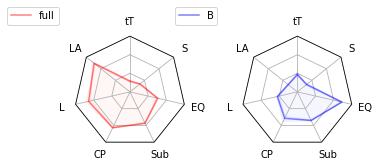

In [18]:
# number of variable
categories=comps
N = len(categories)
# Initialise the spider plot
theta = radar_factory(N, frame='polygon')

fig, axs = plt.subplots(figsize=(5, 2), nrows=1, ncols=2,
                            subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

plot_radar(cp='B', ax=axs[1], color='blue', df_dict=df_dict, n_rep=n_rep)
plot_radar(cp='full', ax=axs[0], color='red', df_dict=df_dict, n_rep=n_rep)

fig.subplots_adjust(wspace=0.5, hspace=1, top=1, bottom=0.01)
fig.savefig('images/permutation_importances_B_full.svg', dpi=300, bbox_inches="tight")
plt.show()

In [19]:
## Detailed study of reaction classes
# Figure 5 is very interesting. Could you better comment on the observations? 
# For example, time and temperature seem only important for the Zn coupling partners? 
# Is this because they were kept constant in all other publications? Similarly, the molar ratios 
# seem to be the only significant feature for the Si coupling partners. Are those artifacts of the dataset? 
# Do the feature importance observations make chemically sense?

In [20]:
# get_variace of each feature then each feature category for all coupling classes
regrouped_vars = dict()
for cp in coupling_partner_classes:
    nicolit_reduced = nicolit_float[nicolit.coupling_partner_class == cp]
    all_vars        = nicolit_reduced.std()
    cp_vars = []
    for i, comp in enumerate([tT, sol, eq, sub, AX, lig, al]):
        cp_vars.append(np.sum(all_vars[comp])/len(comp))
    print(cp, sum(cp_vars))
    regrouped_vars[cp] = np.array(cp_vars)

Li 2.6268476106906524
Zn 2.0111894935810493
RMgX 4.7119401026274454
B 5.804207953208803
C-H 4.865623157891583
NCO 3.502651527657706
CO2 1.9651111985011545
NH 2.32488236097665
Si 2.6998176936773435
Al 2.8794777190578635


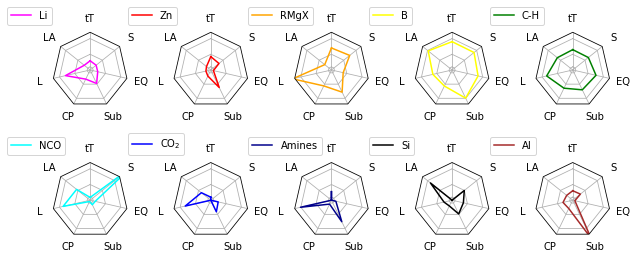

In [21]:
# last plot with the mean variance of each category of variables added
fig, axs = plt.subplots(figsize=(10,  4), nrows=2, ncols=5,
                            subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors= ['magenta', 'red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'Darkblue',
        'black', 'brown']
dict_labels = {'Li':'Li', 'Zn':'Zn', 'RMgX':'RMgX', 'B':'B', 'C-H':'C-H', 
                'NCO':'NCO', 'CO2':'CO$_2$', 'NH':'Amines', 'Si':'Si', 'Al':'Al', 'full': 'full'}
for i, cp  in enumerate(coupling_partner_classes):
    if i < 5:
        ncol = i
        nrow =0
    else:
        ncol = i-5
        nrow=1
#    plot_radar(cp=cp, ax=axs[nrow, ncol], color=colors[i], df_dict=df_dict, n_rep=n_rep)
    axs[nrow, ncol].plot(theta, regrouped_vars[cp], color=colors[i], alpha=1, label=dict_labels[cp])
    axs[nrow, ncol].set_rgrids([0.1, 0.5, 1.0], labels=["","",""])
    axs[nrow, ncol].set_rlim([0,1.2])
    axs[nrow, ncol].set_varlabels(categories_labels)
    axs[nrow, ncol].set_rlabel_position(0)
    axs[nrow, ncol].set_theta_direction(-1)
    axs[nrow, ncol].legend(loc=[-0.6,1.1], fontsize='10')
    
    
fig.subplots_adjust(wspace=0.6, hspace=0.30, top=0.85, bottom=0.05)
fig.savefig('images/permutation_importances_cp_var.png', dpi=300, bbox_inches="tight")
plt.show()

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/c8/7pbzw0r912n01vr9fgdmzhx00000gn/T/ipykernel_83376/3902458959.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zn_tT_origin['Time'] = noizy_time
/var/folders/c8/7pbzw0r912n01vr9fgdmzhx00000gn/T/ipykernel_83376/3902458959.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

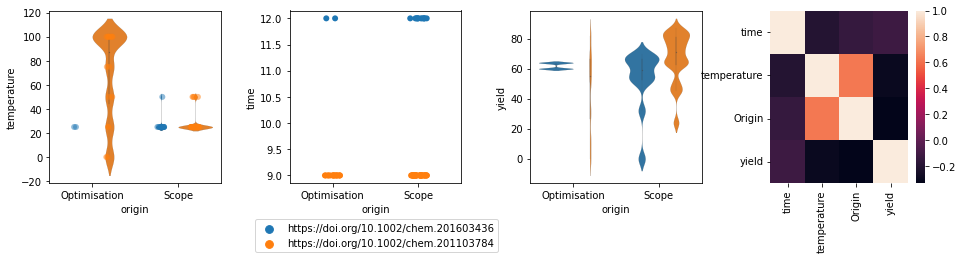

In [24]:
# look correlation between temp value and opt/scope 
# Zn 
nicolit_zn = nicolit[nicolit.coupling_partner_class == 'Zn']
zn_tT_origin = nicolit_zn[['temperature', 'time']]

# esthetic in the plot
noizy_temperature = [i+ 6*np.random.rand(1)[0] for i in zn_tT_origin.temperature]
zn_tT_origin.loc[:, 'Temperature'] = np.array(noizy_temperature)
noizy_time = [i+ 0.5*np.random.rand(1)[0] for i in zn_tT_origin.time]
zn_tT_origin['Time'] = noizy_time

# add origins
zn_tT_origin['origin'] = nicolit[nicolit.coupling_partner_class == 'Zn']["origin"]
zn_tT_origin['Origin'] = [1 if i == 'Optimisation' else 0 for i in zn_tT_origin.origin]
# add yields
zn_tT_origin['yield']  = nicolit[nicolit.coupling_partner_class == 'Zn']["yield"].to_list()
# add doi origin
zn_tT_origin['DOI']  = nicolit[nicolit.coupling_partner_class == 'Zn']["DOI"].to_list()

fig, ax = plt.subplots(1,4, figsize=(16,3))

sns.violinplot(x='origin', y='temperature', hue='DOI',
               data=zn_tT_origin, alpha=0.1, linewidth=0.1,
               showmeans=False, showmedians=False, showextrema=False, bw=.2, ax=ax[0], scale='count')
sns.stripplot(x='origin', y='temperature', hue='DOI',
              data=zn_tT_origin, size=6, alpha = 0.5, dodge=True, ax=ax[0])

sns.stripplot(x='origin', y='time', hue= 'DOI', 
              data=zn_tT_origin, size=6, alpha = 1, dodge=False, ax=ax[1])

sns.violinplot(x='origin', y='yield', hue='DOI',
               data=zn_tT_origin, alpha=0.1, linewidth=0.1,
                showmeans=False, showmedians=False, showextrema=False, bw=.2, ax=ax[2])


zn_tT_origin_val = zn_tT_origin[['time', 'temperature', 'Origin', 'yield']]
sns.heatmap(data=zn_tT_origin_val.corr(), ax=ax[3])

ax[0].get_legend().remove()
ax[1].legend(loc=[-0.2,-0.4])
ax[2].get_legend().remove()

fig.subplots_adjust(wspace=0.4, hspace=0.30, top=0.85, bottom=0.05)
plt.show()

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/c8/7pbzw0r912n01vr9fgdmzhx00000gn/T/ipykernel_83376/1126537296.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmgx_tT_origin['Time'] = noizy_time
/var/folders/c8/7pbzw0r912n01vr9fgdmzhx00000gn/T/ipykernel_83376/1126537296.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

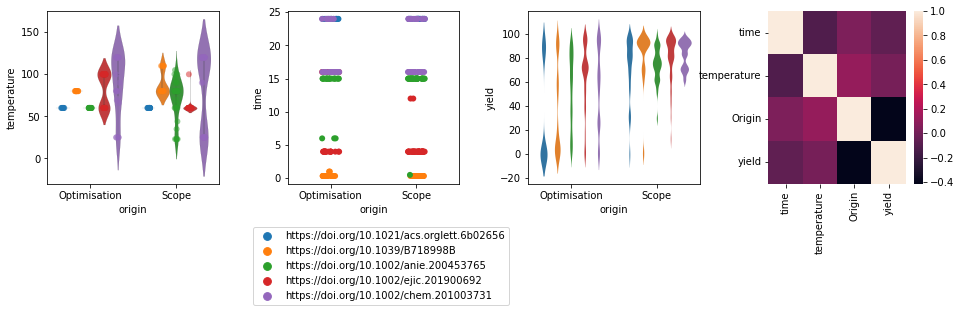

In [25]:
# look correlation between temp value and opt/scope 
# RMgX
nicolit_rmgx = nicolit[nicolit.coupling_partner_class == 'RMgX']
rmgx_tT_origin = nicolit_rmgx[['temperature', 'time']]

# esthetic in the plot
noizy_temperature = [i+ 6*np.random.rand(1)[0] for i in rmgx_tT_origin.temperature]
rmgx_tT_origin.loc[:, 'Temperature'] = np.array(noizy_temperature)
noizy_time = [i+ 0.5*np.random.rand(1)[0] for i in rmgx_tT_origin.time]
rmgx_tT_origin['Time'] = noizy_time

# add origins
rmgx_tT_origin['origin'] = nicolit[nicolit.coupling_partner_class == 'RMgX']["origin"]
rmgx_tT_origin['Origin'] = [1 if i == 'Optimisation' else 0 for i in rmgx_tT_origin.origin]
# add yields
rmgx_tT_origin['yield']  = nicolit[nicolit.coupling_partner_class == 'RMgX']["yield"].to_list()
# add doi origin
rmgx_tT_origin['DOI']  = nicolit[nicolit.coupling_partner_class == 'RMgX']["DOI"].to_list()

fig, ax = plt.subplots(1,4, figsize=(16,3))

sns.violinplot(hue='DOI', y='temperature', x='origin',
               scale_hue=False,
               data=rmgx_tT_origin, alpha=0.1, linewidth=0.1, scale='width',
               ax=ax[0])

sns.stripplot(x='origin', y='temperature', hue='DOI', data=rmgx_tT_origin,
             size=6, alpha = 0.5, dodge=True, ax=ax[0])


sns.stripplot(x='origin', y='time', hue= 'DOI', 
              data=rmgx_tT_origin, size=6, alpha = 1, dodge=False, ax=ax[1])

sns.violinplot(x='origin', y='yield', hue='DOI',
               data=rmgx_tT_origin, alpha=0.1, linewidth=0,
               scale_hue=False,
               bw=.2, ax=ax[2])


rmgx_tT_origin_val = rmgx_tT_origin[['time', 'temperature', 'Origin', 'yield']]
sns.heatmap(data=rmgx_tT_origin_val.corr(), ax=ax[3])

ax[0].get_legend().remove()
ax[1].legend(loc=[-0.2,-0.7])
ax[2].get_legend().remove()

fig.subplots_adjust(wspace=0.4, hspace=0.30, top=0.85, bottom=0.05)
plt.show()

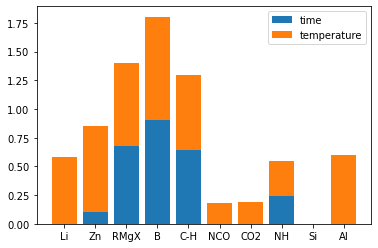

In [26]:
#variability of temperature and times over_all categories
time_temperature = []
for cp in coupling_partner_classes:
    nicolit_reduced = nicolit_float[nicolit.coupling_partner_class == cp]
    all_vars        = nicolit_reduced.std()
    time_temperature.append(all_vars[['time', 'temperature']].to_list())

plt.bar([i for i in range(len(coupling_partner_classes))], np.array(time_temperature)[:,0], label='time')
plt.bar([i for i in range(len(coupling_partner_classes))], np.array(time_temperature)[:,1], 
        bottom=np.array(time_temperature)[:,0], label='temperature')
plt.legend()
plt.xticks(ticks = [i for i in range(len(coupling_partner_classes))], labels= coupling_partner_classes)
plt.show()

In [27]:
rel_var_tT = []
for cp in coupling_partner_classes:
    rel_var_tT.append(regrouped_vars[cp][0]/np.sum(regrouped_vars[cp]))

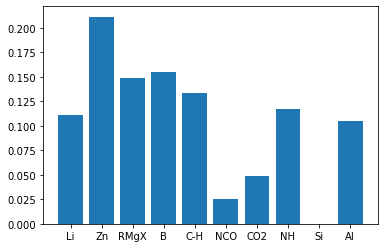

In [28]:
# relative variability
plt.bar([i for i in range(len(coupling_partner_classes))], rel_var_tT)
plt.xticks(ticks = [i for i in range(len(coupling_partner_classes))], labels= coupling_partner_classes)
plt.show()

In [33]:
# analysis of TSNE of Zn coloured by temperatures and time
nicolit_float_zn = nicolit_zn.select_dtypes(include=np.float64)
X_zn = nicolit_float_zn.drop(columns=['yield', 'polarisabilite', 'Unnamed: 9']).values

from sklearn.manifold import TSNE
tsne = TSNE(init='pca')
tsne_zn = tsne.fit_transform(X_zn)

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


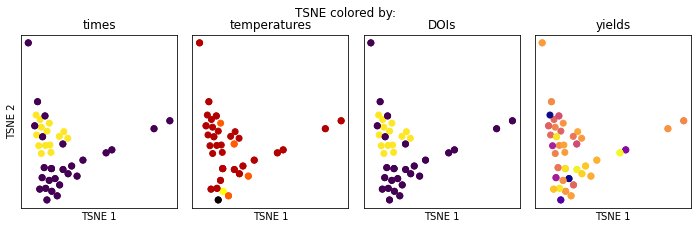

In [34]:
import matplotlib.cm as cm

times = nicolit_float_zn.time.to_list()
times = np.array(times)/max(times)
temperatures = nicolit_float_zn.temperature.to_list()
temperatures = np.array(temperatures)/max(temperatures)
dois = nicolit[nicolit['coupling_partner_class'] == 'Zn'].DOI.to_list()
c_dois = [1 if i == dois[0] else 0 for i in dois]
yields = nicolit_float_zn['yield'].to_list()
yields = np.array(yields)/max(yields)


fig,ax =plt.subplots(1,4, figsize=(12,3))

ax[0].scatter(tsne_zn[:,0], tsne_zn[:,1], c=times, cmap='viridis')
ax[1].scatter(tsne_zn[:,0], tsne_zn[:,1], c=temperatures, cmap='hot')
ax[2].scatter(tsne_zn[:,0], tsne_zn[:,1], c=c_dois, cmap='viridis')
ax[3].scatter(tsne_zn[:,0], tsne_zn[:,1], c=yields, cmap='plasma')

titles = ['times', 'temperatures', 'DOIs', 'yields']
ax[0].set_ylabel("TSNE 2")
for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_xlabel("TSNE 1")
    ax[i].set_yticks([])
    ax[i].set_title(titles[i])

plt.suptitle("TSNE colored by:")
fig.subplots_adjust(wspace=0.1, hspace=0.05, top=0.85, bottom=0.05)

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


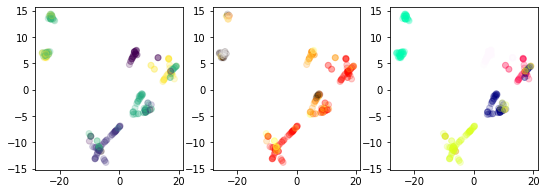

In [35]:
nicolit_float_rmgx = nicolit_rmgx.select_dtypes(include=np.float64)
nicolit_float_rmgx.dropna(axis=1, inplace=True)
X_rmgx = nicolit_float_rmgx.drop(columns=['yield']).values

tsne = TSNE(init='random')
tsne_rmgx = tsne.fit_transform(X_rmgx)

times = nicolit_float_rmgx.time.to_list()
times = np.array(times)/max(times)
temperatures = nicolit_float_rmgx.temperature.to_list()
temperatures = np.array(temperatures)/max(temperatures)
dois = nicolit[nicolit['coupling_partner_class'] == 'RMgX'].DOI.to_list()
unik_dois = list(np.unique(dois))

c_dois = [unik_dois.index(i) for i in dois]
fig,ax =plt.subplots(1,3, figsize=(9,3))

ax[0].scatter(tsne_rmgx[:,0], tsne_rmgx[:,1], alpha=0.2, c=times, cmap='viridis')
ax[1].scatter(tsne_rmgx[:,0], tsne_rmgx[:,1], alpha=0.2, c=temperatures, cmap='hot')
ax[2].scatter(tsne_rmgx[:,0], tsne_rmgx[:,1], alpha=0.2, c=c_dois, cmap='gist_ncar')

plt.show()

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


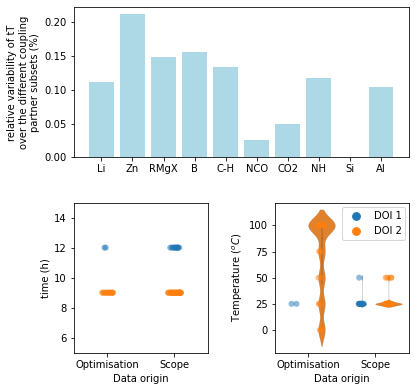

In [36]:
# figure for Zn
short_doi =[]
for i in zn_tT_origin.DOI:
    if i == 'https://doi.org/10.1002/chem.201603436':
        short_doi.append('DOI 1')
    elif i == 'https://doi.org/10.1002/chem.201103784':
        short_doi.append('DOI 2')
    elif i == '10.1002/chem.201103784':
        short_doi.append('DOI 2')
    elif i == '10.1002/chem.201603436':
        short_doi.append('DOI 1')
    else:
        short_doi.append(i)

zn_tT_origin.DOI = short_doi

fig = plt.figure(figsize=(6,6))

# Plot 1
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.bar([i for i in range(len(coupling_partner_classes))], rel_var_tT, color='lightblue')
ax1.set_xticks([i for i in range(len(coupling_partner_classes))]) 
ax1.set_xticklabels(coupling_partner_classes)
ax1.set_ylabel("relative variability of tT\nover the different coupling\npartner subsets (%)")

# Plot 3
ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
sns.violinplot(x='origin', y='temperature', hue='DOI',
               data=zn_tT_origin, alpha=0.1, linewidth=0.1,
               showmeans=False, showmedians=False, showextrema=False, bw=.2, ax=ax3, scale='count')
sns.stripplot(x='origin', y='temperature', hue='DOI',
              data=zn_tT_origin, size=6, alpha = 0.5, dodge=True, ax=ax3)
ax3.get_legend().remove()
ax3.set_ylabel("Temperature ($^{o}C$)")
ax3.set_xlabel("Data origin")

# Plot 2
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
sns.stripplot(x='origin', y='time', hue= 'DOI', 
              data=zn_tT_origin, size=6, alpha = 0.5, dodge=False, ax=ax2)

ax2.set_ylim([5,15])
ax2.set_ylabel("time (h)")
ax2.legend(loc=[2,0.75])
ax2.set_xlabel("Data origin")

# Show the graph

fig.subplots_adjust(wspace=0.5, hspace=0.3, top=0.85, bottom=0.05)
fig.savefig('images/zn_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


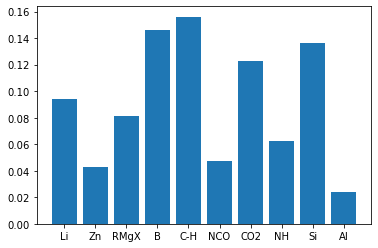

In [37]:
# Si
idx = categories_labels.index('EQ')

# analysis of the molar ratios
rel_var_eq = []
for cp in coupling_partner_classes:
    rel_var_eq.append(regrouped_vars[cp][idx]/np.sum(regrouped_vars[cp]))
    
# relative variability
plt.bar([i for i in range(len(coupling_partner_classes))], rel_var_eq)
plt.xticks(ticks = [i for i in range(len(coupling_partner_classes))], labels= coupling_partner_classes)
plt.show()

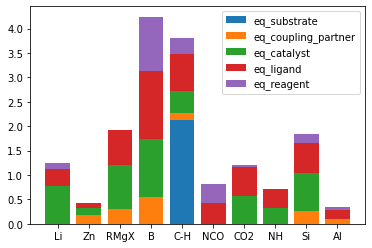

In [38]:
Eqs = []
eq = [i for i in nicolit_float.columns if 'eq_' in i]
for cp in coupling_partner_classes:
    nicolit_reduced = nicolit_float[nicolit.coupling_partner_class == cp]
    all_vars        = nicolit_reduced.std()
    Eqs.append(np.array(all_vars[eq]))

plt.bar([i for i in range(len(coupling_partner_classes))], np.array(Eqs)[:,0], label=eq[0])
plt.bar([i for i in range(len(coupling_partner_classes))], np.array(Eqs)[:,1], 
        bottom=np.array(Eqs)[:,0], label=eq[1])
plt.bar([i for i in range(len(coupling_partner_classes))], np.array(Eqs)[:,2], 
        bottom=np.array(Eqs)[:,0]+np.array(Eqs)[:,1], label=eq[2])
plt.bar([i for i in range(len(coupling_partner_classes))], np.array(Eqs)[:,3], 
        bottom=np.array(Eqs)[:,0]+np.array(Eqs)[:,1]+np.array(Eqs)[:,2], label=eq[3])
plt.bar([i for i in range(len(coupling_partner_classes))], np.array(Eqs)[:,4],
        bottom=np.array(Eqs)[:,0]+np.array(Eqs)[:,1]+np.array(Eqs)[:,2]+np.array(Eqs)[:,3], label=eq[4])
plt.legend()
plt.xticks(ticks = [i for i in range(len(coupling_partner_classes))], labels= coupling_partner_classes)
plt.show()

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


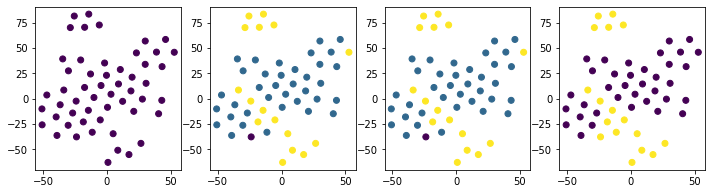

In [39]:
nicolit_si = nicolit[nicolit.coupling_partner_class == 'Si']
nicolit_float_si = nicolit_si.select_dtypes(include=np.float64)
nicolit_float_si.dropna(axis=1, inplace=True)
X_si = nicolit_float_si.drop(columns=['yield']).values

tsne = TSNE()
tsne_si = tsne.fit_transform(X_si)

yields_si = nicolit_float_si['yield'].to_list()
eq_sub = nicolit_float_si.eq_substrate.to_list()
eq_sub = np.array(eq_sub)/max(eq_sub)
eq_cat = nicolit_float_si.eq_catalyst.to_list()
eq_cat = np.array(eq_cat)/max(eq_cat)
eq_lig = nicolit_float_si.eq_ligand.to_list()
eq_lig = np.array(eq_lig)/max(eq_lig)

scope_opt = nicolit[nicolit.coupling_partner_class == 'Si'].origin.to_list()
scope_opt = [1 if i == 'Optimisation' else 0 for i in scope_opt]

fig,ax =plt.subplots(1,4, figsize=(12,3))
ax[0].scatter(tsne_si[:,0], tsne_si[:,1], c=eq_sub, cmap='viridis')
ax[1].scatter(tsne_si[:,0], tsne_si[:,1], c=eq_cat, cmap='viridis')
ax[2].scatter(tsne_si[:,0], tsne_si[:,1], c=eq_lig, cmap='viridis')
ax[3].scatter(tsne_si[:,0], tsne_si[:,1], c=scope_opt, cmap='viridis')

plt.show()

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an e

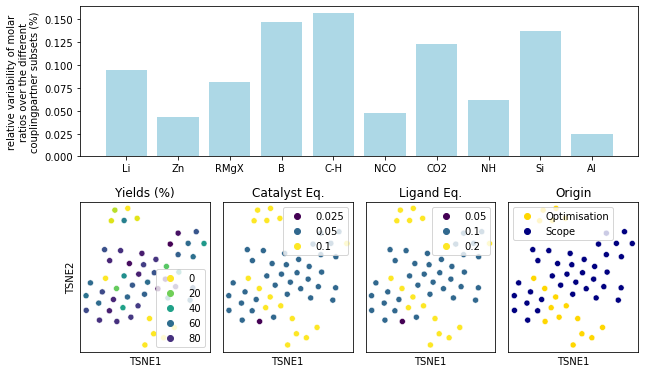

In [40]:
# figure for Si

fig = plt.figure(figsize=(10,6))

# Plot 1
ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
#ax1.bar([i for i in range(len(coupling_partner_classes))], rel_var_eq, color='light_blue')
ax1.bar([i for i in range(len(coupling_partner_classes))], rel_var_eq, color='lightblue')
ax1.set_xticks([i for i in range(len(coupling_partner_classes))]) 
ax1.set_xticklabels(coupling_partner_classes)
ax1.set_ylabel("relative variability of molar\nratios over the different\ncouplingpartner subsets (%)")



# Plot 2
ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=1)
sns.scatterplot(tsne_si[:,0], tsne_si[:,1], c=yields_si, palette='viridis_r',
               hue=yields_si)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel("TSNE2")
ax2.set_xlabel("TSNE1")
ax2.set_title("Yields (%)")



# Plot 3
ax3 = plt.subplot2grid((2, 4), (1, 1), colspan=1)
#ax3.scatter(tsne_si[:,0], tsne_si[:,1], c=eq_cat, cmap='viridis')
sns.scatterplot(tsne_si[:,0], tsne_si[:,1], c=eq_cat, palette='viridis',
               hue=nicolit_float_si.eq_catalyst.to_list())

ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel("TSNE1")
ax3.set_title("Catalyst Eq.")

# Plot 4
ax4 = plt.subplot2grid((2, 4), (1, 2), colspan=1)
sns.scatterplot(tsne_si[:,0], tsne_si[:,1], c=eq_lig, palette='viridis',
               hue=nicolit_float_si.eq_ligand.to_list())

ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_xlabel("TSNE1")
ax4.set_title("Ligand Eq.")

# Plot 5
ax5 = plt.subplot2grid((2, 4), (1, 3), colspan=1)
sns.scatterplot(tsne_si[:,0], tsne_si[:,1], c=scope_opt, palette=['gold', 'navy'], hue=nicolit[nicolit.coupling_partner_class == 'Si'].origin.to_list())

ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_xlabel("TSNE1")
ax5.set_title("Origin")




# Show the graph

fig.subplots_adjust(wspace=0.1, hspace=0.3, top=0.85, bottom=0.05)
fig.savefig('images/si_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.scatter(eq_cat, yields_si)